# Traffic Speed Prediction (LA case)
by Da Lei

We will walk through the following steps: 
1.   Installation and Setup
2.   Creating a dataloader
3.   Building the Model
4.   Creating train and evaluation functions
5.   Train the model
6.   Test the model



## Installation and setup

We recommend using a GPU for running our project.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
print(torch.__version__)

Using cuda
1.12.1


d:\ProgramData\Anaconda3\user\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Install PyTorch, PyG, and other necessary python libraries

Mount google for output directories

In [2]:
%ls

 Volume in drive D is New Volume
 Volume Serial Number is A472-BD04

 Directory of d:\research\ST_GAT_Traffic_Speed_Prediction_with_Partial_Sensor_Network

10/07/2022  10:56 AM    <DIR>          .
10/01/2022  02:53 AM    <DIR>          ..
09/29/2022  07:06 PM                43 .gitattributes
10/03/2022  01:56 PM                58 .gitignore
10/01/2022  11:37 PM    <DIR>          __pycache__
10/04/2022  03:53 AM         1,040,006 00_DataPreprocessing.ipynb
10/06/2022  02:22 AM            39,201 01_ST_GAT_Traffic_Speed_Prediction_with_Partial_Sensor_Network_(Kowlong).ipynb
10/10/2022  05:58 AM           126,483 02_LA_case.ipynb
09/28/2022  05:55 AM    <DIR>          cache
10/03/2022  10:15 PM    <DIR>          dataset
09/27/2022  12:23 AM             1,480 feature_propagation.py
10/03/2022  08:28 AM    <DIR>          figs
09/27/2022  12:23 AM             2,448 filling_strategies.py
09/28/2022  04:50 AM    <DIR>          HK_traffic_speed
09/28/2022  04:05 AM     1,315,467,559 HK_traffic_s

## Creating a Dataloader
Now, we create a dataloader which will process data from `.csv` files into a PyTorch Geometric dataset. 

In [3]:
import torch
import numpy as np
import pandas as pd
import os
from torch_geometric.data import InMemoryDataset, Data
from shutil import copyfile

# ipdb.set_trace()

def distance_to_weight(W, sigma2=0.1, epsilon=0.5, gat_version=False):
    """"
    Given distances between all nodes, convert into a weight matrix
    :param W distances
    :param sigma2 User configurable parameter to adjust sparsity of matrix
    :param epsilon User configurable parameter to adjust sparsity of matrix
    :param gat_version If true, use 0/1 weights with self loops. Otherwise, use float
    """
    n = W.shape[0]
    W = W / 10000.
    W2, W_mask = W * W, np.ones([n, n]) - np.identity(n)
    # refer to Eq.10
    W = np.exp(-W2 / sigma2) * (np.exp(-W2 / sigma2) >= epsilon) * W_mask

    # If using the gat version of this, round to 0/1 and include self loops
    if gat_version:
      W[W>0] = 1
      W += np.identity(n)

    return W

class TrafficDataset(InMemoryDataset):
    """
    Dataset for Graph Neural Networks.
    """
    def __init__(self, config, W, root='', drop_nodes=False, drop_rate = 0.0,transform=None, pre_transform=None):
        self.config = config
        self.W = W
        self.drop_nodes = drop_nodes
        self.drop_rate = drop_rate
        # ipdb.set_trace()
        super().__init__(root, transform, pre_transform) # would call __init__ of Class InMemoryDataset
        self.data, self.slices, self.n_node, self.mean, self.std_dev = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [os.path.join(self.raw_dir, 'PeMSD7_V_228.csv')]

    @property
    def processed_file_names(self):
        return ['./data_LA_{}_{}.pt'.format(self.drop_rate, self.config['N_PRED'])]

    def download(self):
        copyfile('./dataset/PeMSD7_V_228.csv', os.path.join(self.raw_dir, 'PeMSD7_V_228.csv'))

    def process(self):
        """
        Process the raw datasets into saved .pt dataset for later use.
        Note that any self.fields here wont exist if loading straight from the .pt file
        """
        # Data Preprocessing and loading
        # ipdb.set_trace()
        data = pd.read_csv(self.raw_file_names[0], header=None).values

        # Technically using the validation and test datasets here, but it's fine, would normally get the
        # mean and std_dev from a large dataset
        mean =  np.mean(data)
        std_dev = np.std(data)
        data = z_score(data, np.mean(data), np.std(data))

        _, n_node = data.shape
        n_window = self.config['N_PRED'] + self.config['N_HIST']

        edge_index_ls_o = []
        edge_index_ls_d = []
        edge_attr = []
        for i in range(n_node):
          for j in range(n_node):
            if self.W[i,j] != 0:
              edge_index_ls_o.append(i)
              edge_index_ls_d.append(j)
              edge_attr.append(self.W[i,j])
        edge_index = torch.tensor([edge_index_ls_o, edge_index_ls_d], dtype=torch.long)
        edge_attr = torch.tensor(edge_attr).resize_(edge_index.shape[1], 1)

        sequences = []
        # T x F x N
        for i in range(self.config['N_DAYS']):
            for j in range(self.config['N_SLOT']):
                # for each time point construct a different graph with data object
                # Docs here: https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data
                g = Data()
                g.__num_nodes__ = n_node

                g.edge_index = edge_index
                g.edge_attr  = edge_attr

                # (F,N) switched to (N,F)
                sta = i * self.config['N_DAY_SLOT'] + j
                end = sta + n_window
                # [21, 228]

                full_window = np.swapaxes(data[sta:end, :], 0, 1) # https://numpy.org/doc/stable/reference/generated/numpy.swapaxes.html
                x = torch.FloatTensor(full_window[:, 0:self.config['N_HIST']])
                if self.drop_nodes:
                  from filling_strategies import filling
                  from utils import get_missing_feature_mask
                  # randomly remove all of a nodes features
                  missing_feature_mask = get_missing_feature_mask(rate=self.drop_rate, n_nodes=n_node, n_features = self.config['N_HIST'], type="structural")
                  x[~missing_feature_mask] = float("nan") # filling missing position using nan
                  filled_feature = filling("feature_propagation", edge_index, x, missing_feature_mask, num_iterations=40)

                  x = torch.where(missing_feature_mask, x, filled_feature)

                g.x = x
                g.y = torch.FloatTensor(full_window[:, self.config['N_HIST']::])
                g.train_mask = missing_feature_mask[:, 0]
                sequences += [g]

        # Make the actual dataset
        data, slices = self.collate(sequences)
        torch.save((data, slices, n_node, mean, std_dev), self.processed_paths[0])

def get_splits(dataset: TrafficDataset, n_slot, splits):
    """
    Given the data, split it into random subsets of train, val, and test as given by splits
    :param dataset: TrafficDataset object to split
    :param n_slot: Number of possible sliding windows in a day
    :param splits: (train, val, test) ratios
    """
    split_train, split_val, _ = splits
    i = n_slot*split_train
    j = n_slot*split_val
    train = dataset[:i]
    val = dataset[i:i+j]
    test = dataset[i+j:]

    return train, val, test


# Build the Model

Using PyG's built in layers. 

Ths model is a Pytorch model containing an initialization function for setting up the model architecture, and a forward function for performing a forward pass of data through the model.

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
class ST_GAT(torch.nn.Module):

    def __init__(self, in_channels, out_channels, n_nodes, device, heads=8, dropout=0.0):
        """
        Initialize the ST-GAT model
        :param in_channels Number of input channels
        :param out_channels Number of output channels
        :param n_nodes Number of nodes in the graph
        :param heads Number of attention heads to use in graph
        :param dropout Dropout probability on output of Graph Attention Network
        """
        super(ST_GAT, self).__init__()
        self.n_pred = out_channels
        self.heads = heads
        self.dropout = dropout
        self.n_nodes = n_nodes

        lstm1_hidden_size = 32
        lstm2_hidden_size = 128
        self.device = device

        # single graph attentional layer with 8 attention heads
        self.gat1 = GATConv(in_channels=in_channels, out_channels=in_channels,
            heads=heads, dropout=0, concat=False)
        
        self.gat2 = GATConv(in_channels=in_channels, out_channels=in_channels,
            heads=heads, dropout=0, concat=False)
        
        self.gat3 = GATConv(in_channels=in_channels, out_channels=in_channels,
            heads=heads, dropout=0, concat=False)
        

        # add two LSTM layers
        self.lstm1 = torch.nn.LSTM(input_size=self.n_nodes, hidden_size=lstm1_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        self.lstm2 = torch.nn.LSTM(input_size=lstm1_hidden_size, hidden_size=lstm2_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)

        # fully-connected neural network
        self.linear = torch.nn.Linear(lstm2_hidden_size, self.n_nodes*self.n_pred)
        torch.nn.init.xavier_uniform_(self.linear.weight)
    
        def attn(self, lstm_output, h_t):
            # lstm_output [3, 10, 16]  h_t[10, 16]
            h_t = h_t.unsqueeze(0)
            # [10, 16, 1]
            h_t = h_t.permute(1, 2, 0)
            lstm_output = lstm_output.permute(1, 0, 2)

            attn_weights = torch.bmm(lstm_output, h_t)
            attn_weights = attn_weights.permute(1, 0, 2).squeeze()

            # [3, 10]
            attention = F.softmax(attn_weights, 1)
            # bmm: [10, 16, 3] [10, 3, 1]

            attn_out = torch.bmm(lstm_output.transpose(1, 2), attention.unsqueeze(-1).transpose(1,0))
            return attn_out.squeeze()

    def forward(self, data, device):
        """
        Forward pass of the ST-GAT model
        :param data Data to make a pass on
        :param device Device to operate on
        """
        x, edge_index = data.x, data.edge_index
        # apply dropout
        if device == 'cpu':
            x = torch.FloatTensor(x)
        else:
            x = torch.cuda.FloatTensor(x)

        # gat layer: output of gat: [11400, 12]
        x = self.gat1(x, edge_index)
        
        bns1 = torch.nn.BatchNorm1d(x.shape[1]).to(device)
        x = bns1(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gat3(x, edge_index)
        x = F.dropout(x, self.dropout, training=self.training)

        # RNN: 2 LSTM
        # [batchsize*n_nodes, seq_length] -> [batch_size, n_nodes, seq_length]
        batch_size = data.num_graphs
        n_node = int(data.num_nodes/batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        # for lstm: x should be (seq_length, batch_size, n_nodes)
        # sequence length = 12, batch_size = 50, n_node = 228
        x = torch.movedim(x, 2, 0)
        # [12, 50, 228] -> [12, 50, 32]
        x, _ = self.lstm1(x)
        bns2 = torch.nn.BatchNorm1d(x.shape[1]).to(device)
        x = bns2(x)
        x = F.dropout(x, self.dropout, training=self.training)
        # [12, 50, 32] -> [12, 50, 128]
        x, _ = self.lstm2(x)
        bns3 = torch.nn.BatchNorm1d(x.shape[1]).to(device)
        x = bns3(x)
        x = F.dropout(x, self.dropout, training=self.training)
        # ipdb.set_trace()
        # Output contains h_t for each timestep, only the last one has all input's accounted for
        # [12, 50, 128] -> [50, 128]
        x = torch.squeeze(x[-1, :, :])
        # [50, 128] -> [50, 228*9]
        x = self.linear(x)

        # Now reshape into final output
        s = x.shape
        # [50, 228*9] -> [50, 228, 9]
        x = torch.reshape(x, (s[0], self.n_nodes, self.n_pred))
        # [50, 228, 9] ->  [11400, 9]
        x = torch.reshape(x, (s[0]*self.n_nodes, self.n_pred))
        return x


## Create Train and Evaluation functions

Create a train function which performs a forward and a backward pass using the model.

Create an evaluation function which performs only a forward pass using the model.

These functions will be used in various stages of overall model training and testing.

In [5]:
@torch.no_grad()
def eval(model, device, dataloader, type=''):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param type Name of evaluation type, e.g. Train/Val/Test
    """
    model.eval()
    model.to(device)

    mae = 0
    rmse = 0
    mape = 0
    n = 0

    # Evaluate model on all data
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch, device)
            truth = batch.y.view(pred.shape)
            if i == 0:
                y_pred = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
                y_truth = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
            truth = un_z_score(truth, dataloader.dataset.mean, dataloader.dataset.std_dev)
            pred = un_z_score(pred, dataloader.dataset.mean, dataloader.dataset.std_dev)
            y_pred[i, :pred.shape[0], :] = pred
            y_truth[i, :pred.shape[0], :] = truth
            rmse += RMSE(truth, pred)
            mae += MAE(truth, pred)
            mape += MAPE(truth, pred)
            n += 1
    rmse, mae, mape = rmse / n, mae / n, mape / n

    # print(f'{type}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')

    #get the average score for each metric in each batch
    return mae, rmse, mape, y_pred, y_truth

def train(model, device, dataloader, optimizer, loss_fn, epoch):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param optimizer Optimizer to use
    :param loss_fn Loss function
    :param epoch Current epoch
    """
    model.train()
    # leave=False to remove process bar after one epoch has completed
    for _, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)):
        batch = batch.to(device)
        optimizer.zero_grad()
        y_pred = torch.squeeze(model(batch, device))
        loss = loss_fn()(y_pred[batch.train_mask].float(), torch.squeeze(batch.y[batch.train_mask]).float())

        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        # loss = loss + 0.0001 * l2_norm

        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()

    return loss

In order to evaluation the performance of the model, we need to define some evaluation metrics.  

*   The Z-score normalizes data using mean and std deviation.
*   MAPE is mean average percentage error. 
*   RMSE is root mean square error.
*   MAE is mean absolute error. 





In [6]:
def z_score(x, mean, std):
    """
    Z-score normalization function: $z = (X - \mu) / \sigma $,
    where z is the z-score, X is the value of the element,
    $\mu$ is the population mean, and $\sigma$ is the standard deviation.
    :param x: torch array, input array to be normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    :return: torch array, z-score normalized array.
    """
    return (x - mean) / std

def un_z_score(x_normed, mean, std):
    """
    Undo the Z-score calculation
    :param x_normed: torch array, input array to be un-normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    """
    return x_normed * std  + mean


def MAPE(v, v_):
    """
    Mean absolute percentage error, given as a % (e.g. 99 -> 99%)
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAPE averages on all elements of input.
    """
    return torch.mean(torch.abs((v_ - v)) /(v + 1e-15) * 100)


def RMSE(v, v_):
    """
    Mean squared error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, RMSE averages on all elements of input.
    """
    return torch.sqrt(torch.mean((v_ - v) ** 2))


def MAE(v, v_):
    """
    Mean absolute error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAE averages on all elements of input.
    """
    return torch.mean(torch.abs(v_ - v))

Now, let's put it all together. Let's use the `train` and `eval` functions along with the model and dataloadres to create a training function (`model_train`) and testing function (`model_test`).

We also build in tensorboard support for logging of the training metrics over time.


In [7]:
import torch
import torch.optim as optim
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

def model_train(train_dataloader, val_dataloader, config, device):
    """
    Train the ST-GAT model. Evaluate on validation dataset as you go.
    :param train_dataloader Data loader of training dataset
    :param val_dataloader Dataloader of val dataset
    :param config configuration to use
    :param device Device to evaluate on
    """

    # Make the model. Each datapoint in the graph is 228x12: N x F (N = # nodes, F = time window)
    model = ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_nodes=config['N_NODE'], device=device, dropout=config['DROPOUT'])
    # reset the parameters to initial random value
    # model.reset_parameters()
    optimizer = optim.Adam(model.parameters(), lr=config['INITIAL_LR'], weight_decay=config['WEIGHT_DECAY'])
    loss_fn = torch.nn.MSELoss
    best_model = None
    best_valid_mae = 99
    model.to(device)

    # For every epoch, train the model on training dataset. Evaluate model on validation dataset
    for epoch in range(config['EPOCHS']):
        loss = train(model, device, train_dataloader, optimizer, loss_fn, epoch)
        # print(f"Loss: {loss:.3f}")
        train_mae, train_rmse, train_mape, _, _ = eval(model, device, train_dataloader, 'Train')
        val_mae, val_rmse, val_mape, _, _ = eval(model, device, val_dataloader, 'Valid')

        writer.add_scalar(f"MAE/train", train_mae, epoch)
        writer.add_scalar(f"RMSE/train", train_rmse, epoch)
        writer.add_scalar(f"MAPE/train", train_mape, epoch)
        writer.add_scalar(f"MAE/val", val_mae, epoch)
        writer.add_scalar(f"RMSE/val", val_rmse, epoch)
        writer.add_scalar(f"MAPE/val", val_mape, epoch)
        if val_mae < best_valid_mae:
          best_model = model
          
        #   print(f"Best MAE/val", val_mae.cpu().detach().numpy(), epoch)
          best_valid_mae = val_mae
          best_val_rmse = val_rmse
          best_val_mape = val_mape

    print(f"Final Best MAE/val", best_valid_mae.cpu().detach().numpy(), epoch)
    # Save the model
    print()
    timestr = time.strftime("%m-%d-%H%M%S")
    torch.save({
            "epoch": epoch,
            "model_state_dict": best_model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
            "best_valid_mae":best_valid_mae,
            "best_val_rmse":best_val_rmse,
            "best_val_mape":best_val_mape,
            "config":config,
            }, os.path.join(config["CHECKPOINT_DIR"], f"LA_model_{config['N_PRED']}_{config['drop_rate']}_{timestr}.pt"))

    return best_model

def model_test(model, test_dataloader, device, config):
    """
    Test the ST-GAT model
    :param test_dataloader Data loader of test dataset
    :param device Device to evaluate on
    """
    _, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')


##Start training

Now with all code in place, let's set up config, load our dataset, and start training!

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./runs --host localhost --port 8888

Now, create your dataloaders and start training!

In our default configuration, we train for 60 epochs with a batch size of 50. You can view your training progress in the tensorboard above by clicking the "refresh" button to see new data. Training and validation performance are updated every 5 epochs.

In [ ]:
from torch_geometric.loader import DataLoader

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

for each_N_PRED in [3,6,9]:
    for each_drop_rate in [0.0, 0.3, 0.6, 0.9]:
        # Make a tensorboard writer
        writer = SummaryWriter()    
# Constant config to use throughout
        config = {
            'BATCH_SIZE': 128,
            'EPOCHS': 200,
            'WEIGHT_DECAY': 5e-5,
            'INITIAL_LR': 3e-4,
            'CHECKPOINT_DIR': './runs',
            'N_PRED': each_N_PRED,
            'N_HIST': 12,
            'DROPOUT': 0.4,
            # number of possible 5 minute measurements per day
            'N_DAY_SLOT': 288,
            # number of days worth of data in the dataset
            'N_DAYS': 44,
            # If false, use GCN paper weight matrix, if true, use GAT paper weight matrix
            'USE_GAT_WEIGHTS': True,
            'N_NODE': 228,
            "drop_nodes": True,
            "drop_rate": each_drop_rate
        }

        # Number of possible windows in a day
        config['N_SLOT']= config['N_DAY_SLOT'] - (config['N_PRED']+config['N_HIST']) + 1

        # Load the weight and dataset dataset
        distances = pd.read_csv('./dataset/PeMSD7_W_228.csv', header=None).values
        W = distance_to_weight(distances, gat_version=config['USE_GAT_WEIGHTS'])
        dataset = TrafficDataset(config, W, drop_nodes = config['drop_nodes'], drop_rate=config['drop_rate'])

        # total of 44 days in the dataset, use 34 for training, 5 for val, 5 for test
        d_train, d_val, d_test = get_splits(dataset, config['N_SLOT'], (34, 5, 5))
        train_dataloader = DataLoader(d_train, batch_size=config['BATCH_SIZE'], shuffle=True)
        val_dataloader = DataLoader(d_val, batch_size=config['BATCH_SIZE'], shuffle=True)
        test_dataloader = DataLoader(d_test, batch_size=config['BATCH_SIZE'], shuffle=False)

        # Get gpu if you can
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using {device}")

        # Configure and train model
        config['N_NODE'] = dataset.n_node
        model = model_train(train_dataloader, val_dataloader, config, device)

# os.system("shutdown")

## Test the model

Now that we have a trained model, we can test it on the test dataset and visualize its performance

In [23]:
from torch_geometric.loader import DataLoader

each_N_PRED = 9
each_drop_rate = 0.6

# Make a tensorboard writer
writer = SummaryWriter()    
# Constant config to use throughout
config = {
    'BATCH_SIZE': 128,
    'EPOCHS': 200,
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 3e-4,
    'CHECKPOINT_DIR': './runs',
    'N_PRED': each_N_PRED,
    'N_HIST': 12,
    'DROPOUT': 0.4,
    # number of possible 5 minute measurements per day
    'N_DAY_SLOT': 288,
    # number of days worth of data in the dataset
    'N_DAYS': 44,
    # If false, use GCN paper weight matrix, if true, use GAT paper weight matrix
    'USE_GAT_WEIGHTS': True,
    'N_NODE': 228,
    "drop_nodes": True,
    "drop_rate": each_drop_rate
}

# Number of possible windows in a day
config['N_SLOT']= config['N_DAY_SLOT'] - (config['N_PRED']+config['N_HIST']) + 1

# Load the weight and dataset dataset
distances = pd.read_csv('./dataset/PeMSD7_W_228.csv', header=None).values
W = distance_to_weight(distances, gat_version=config['USE_GAT_WEIGHTS'])
dataset = TrafficDataset(config, W, drop_nodes = config['drop_nodes'], drop_rate=config['drop_rate'])

# total of 44 days in the dataset, use 34 for training, 5 for val, 5 for test
d_train, d_val, d_test = get_splits(dataset, config['N_SLOT'], (34, 5, 5))
train_dataloader = DataLoader(d_train, batch_size=config['BATCH_SIZE'], shuffle=True)
val_dataloader = DataLoader(d_val, batch_size=config['BATCH_SIZE'], shuffle=True)
test_dataloader = DataLoader(d_test, batch_size=config['BATCH_SIZE'], shuffle=False)

# Get gpu if you can
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

# Configure and train model
config['N_NODE'] = dataset.n_node

Using cuda


In [25]:
model = ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_nodes=config['N_NODE'], dropout=config['DROPOUT'], device=device)
model.load_state_dict(torch.load('./runs/LA_model_9_0.6_10-06-062441.pt')['model_state_dict'])

<All keys matched successfully>

In [29]:
for each_batch in DataLoader(dataset[:2], batch_size=2, shuffle=False):
    each_batch
    break

In [36]:
un_z_score(each_batch.x[~each_batch.train_mask], dataset.mean, dataset.std_dev)

tensor([[71.2357, 68.8545, 68.6240,  ..., 69.8672, 70.4577, 69.1748],
        [65.7203, 65.4864, 65.2532,  ..., 65.0907, 64.8097, 64.6802],
        [67.9957, 67.1329, 66.7890,  ..., 67.0151, 66.9352, 66.4715],
        ...,
        [68.1020, 67.7732, 67.8331,  ..., 66.4935, 66.0979, 67.1722],
        [67.0246, 67.5813, 67.8261,  ..., 66.5747, 66.8312, 66.9107],
        [67.0642, 66.7972, 66.9349,  ..., 65.8113, 65.4922, 66.3162]])

In [38]:
torch.load('./runs/LA_model_9_0.0_10-06-060956.pt')['best_valid_mae']

tensor(3.6367, device='cuda:0')

In [31]:
train_mask

NameError: name 'train_mask' is not defined

In [26]:
_, _, _, y_pred, y_truth = eval(model, device, DataLoader(dataset[:2], batch_size=2, shuffle=False), 'Test')

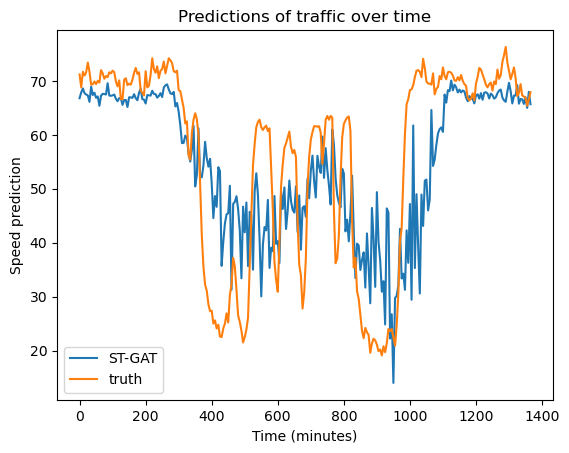

In [17]:
def plot_prediction(test_dataloader, y_pred, y_truth, node, config):
    # Calculate the truth
    s = y_truth.shape
    y_truth = y_truth.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    # just get the first prediction out for the nth node
    y_truth = y_truth[:, :, node, 0]
    # Flatten to get the predictions for entire test dataset
    y_truth = torch.flatten(y_truth)
    day0_truth = y_truth[:config['N_SLOT']]


    # Calculate the predicted
    s = y_pred.shape
    y_pred = y_pred.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    # just get the first prediction out for the nth node
    y_pred = y_pred[:, :, node, 0]
    # Flatten to get the predictions for entire test dataset
    y_pred = torch.flatten(y_pred)
    # Just grab the first day
    day0_pred = y_pred[:config['N_SLOT']]
    t = [t for t in range(0, config['N_SLOT']*5, 5)]
    plt.plot(t, day0_pred, label='ST-GAT')
    plt.plot(t, day0_truth, label='truth')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Speed prediction')
    plt.title('Predictions of traffic over time')
    plt.legend()
    plt.savefig('predicted_times.png')
    plt.show()
    
_, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')
plot_prediction(test_dataloader, y_pred, y_truth, 0, config)

In [21]:
for each_batch in test_dataloader:
    each_batch
    break

In [22]:
each_batch

DataBatch(edge_index=[2, 242176], edge_attr=[242176, 1], x=[29184, 12], y=[29184, 3], train_mask=[29184], batch=[29184], ptr=[129])